z# With lists

## Context

The algorithm did not work as well as expected out of the box.
Because of this, I decided to investigate if it could be a problem with the string distance threshold.
To do so, I manually labeled a bit less than a hundred html pages with the number of data records in them.
A page in a market place website would have as many records as products on that page.
For instance, see [this page](https://www.circuitcity.com/products/health-personal-care-beauty.html): it has 12 records.
Note that, if the algorithm finds, in this case, 12 data records, it does not necessarily means that it worked.
The results might be a completely different part of the HTML page that does not have any value.
However, if it does not have 12 records in the results (or, say, 'almost'), it probably did not find the correct records.
This is reasonable to suppose because the data records, according to the algorithm's assumptions, are usually adjacent.
Therefore, finding the correct region should entail finding the other ones as well.
An exception might occur when there is a disconnected data record - see section 3.4 Data Records not in Data Regions in [?] for further detail.
Fortunately this case will not have a big importance here.
Finally, this 'soft' labelling can be used as an useful way to evaluate if the algorithm is working properly.
Besides, it is laborious to inspect raw HTMLs to figure out rather the data records are correct or not.
Hence, this is also useful to filter out the results and inspect only good candidates more closely.

### List-related HTML tags

The authors are not very precise in the paper about which HTML tags are considered as candidates for data records or not.
They say that they considered table-related tags. However, I found that this is too restrictive and did not find much.
This might be because table tags were more widely used back in the time that the algorithm was developed.
Because of that, I decided to also consider list-related HTML tags and compare the results.

### Node name attribute

While revising and cleaning up the code, I noticed that my implementation might have introduced a bug.
The problem is: to uniquely identify all the nodes in the HTML tree, I added an attribute to the lxml objects' attributes;
it is like any other HTML attribute and, therefore, is included when the object is serialized;
then, the string distance between two nodes is distorted.
I decided to investigate if this factor could be causing the issues by rerunning the tests with a fix.
For simplicity reasons, I did not properly correct the entire implementation.
Instead, at the moment of the serialization, I create a (deep) copy of the object, strip the node name attributes, and use it for computing the string distance.
Notice that this fix might slow down the implementation as the operations mentioned are executed a lot.

## In this notebook

This notebook evaluates the results of the following variation:
- List elements: **yes**
- Node names cleanup: **yes**


In [22]:
import pathlib
%reload_ext autoreload
%autoreload 2


import random
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import typing as t


import core
import files_management as fm
import prepostprocessing as ppp
import utils

MAX_TAGS_PER_GNODE = 10

First, load all the runs (all threshold x all pages).

In [23]:
all_page_metas = fm.PageMeta.get_all()
print("There are {:d} pages in total.".format(len(all_page_metas)))

thresholds: t.List[float] = [th / 100 for th in range(5, 50 + 1)]
thresholds_strs = {th: "{:.2f}".format(th) for th in thresholds}
th_strs = [thresholds_strs[th] for th in thresholds]
thresholds_objs: t.Dict[float, core.MDREditDistanceThresholds] = {
    th: core.MDREditDistanceThresholds.all_equal(th) for th in thresholds
}
print("There are {:d} thresholds.".format(len(thresholds)))

all_page_metas: t.Dict[str, fm.PageMeta] = {
    k: v for k, v in all_page_metas.items() 
    if all(v.data_records_pkl(th, MAX_TAGS_PER_GNODE).exists() for th in thresholds_objs.values())
}
print("There are {:d} processed pages.".format(len(all_page_metas)))

There are 94 pages in total.
There are 46 thresholds.
There are 86 processed pages.


In [24]:
drs_by_run: t.Dict[t.Tuple[fm.PageMeta, float], t.Set[core.DataRegion]] = {
    (pmid, th): pm.load_precomputed_data_regions(th, MAX_TAGS_PER_GNODE)
    for th in thresholds
    for pmid, pm in all_page_metas.items()
}
print("There are {:d} runs of data regions.".format(len(drs_by_run)))


There are 3956 runs of data regions.


In [25]:
drecs_by_run: t.Dict[t.Tuple[str, float], t.Set[core.DataRecord]] = {
    (pmid, th): pm.load_precomputed_data_records(thresholds_objs[th], MAX_TAGS_PER_GNODE)
    for th in thresholds
    for pmid, pm in all_page_metas.items()
}
print("There are {:d} runs.".format(len(drecs_by_run)))

There are 3956 runs.


Find all the websites in the results.

In [26]:
def get_website(url: str) -> str:
    website = url.split("//")[1].split(".com")[0]
    website = website if "www." not in website else website.split("www.")[1]
    return website

websites = {get_website(pm.url) for pm in all_page_metas.values()}

Put the results in a `pandas.DataFrame`.

In [27]:
import pandas as pd

# pmid = page meta id, gd = ground truth
df = pd.DataFrame(
    columns=["pmid", "website", "gd"] + [thresholds_strs[th] for th in thresholds],
    data=[
        [
            pmid, get_website(pm.url), pm.n_data_records
        ] + [
            len(drecs_by_run[(pmid, th)]) for th in thresholds
        ] 
        for pmid, pm in all_page_metas.items()
    ]
)

In [28]:
def get_data_points_within_margin(pm: fm.PageMeta, size=5) -> t.Tuple[np.array, np.array, np.array]:
    """ 
    This is used to find threshold parameters such that the number of data records found stays inside a margin
    of +/- size for a given page.
     
    Returns: 
        (thresholds, nb_drecs, relative_nb_drecs): relative to the ground truth
    """
    pmrow = df[df.pmid == pm.page_id].iloc[0]
    vals = pmrow[th_strs].values
    low = pmrow.gd - size
    up = pmrow.gd + size
    withing = (vals >= low) & (vals <= up)
    ths = np.array(th_strs)
    nb_drecs = pmrow[ths[withing]].values
    ths = np.array(thresholds)[withing]
    return ths, nb_drecs, nb_drecs - pmrow.gd


In [29]:
# get a DataFrame with the relative number of data records (relative to the ground truth).

df_diff = deepcopy(df)
df_diff[df_diff.columns[3:]] = df_diff[th_strs].values - df_diff.gd.values.reshape(-1, 1)
df_diff.head(2)

,pmid,website,gd,0.05,0.06,0.07,0.08,0.09,0.10,0.11,...,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.50
0,0d6-30e-a27,nothingbutsavings,24,-18,-14,-5,1,1,9,13,...,46,46,46,46,46,48,48,48,45,49
1,185-0cc-e49,circuitcity,12,-12,-12,-10,-10,-10,-10,-10,...,46,47,47,49,50,50,53,53,56,56


The following methods are used to visualize the results.

In [45]:
noises = np.random.uniform(-1, 1, len(thresholds))


def viz_page_results(pm: fm.PageMeta, figsize=None):
    """
    Plot the number of data records of all the thresholds of a single page.
    Number of data records on the y-axis.

    Args:
        pm:
        figsize:

    Returns:

    """
    row = df[df.pmid == pm.page_id].iloc[0]
    
    fig = plt.figure(figsize=figsize or (5, 5), dpi=120)
    ax = fig.gca()
    xs, ys = noises, np.array([row.get(th) for th in thresholds_strs.values()])
    ax.scatter(0, row.gd)
    ax.scatter(xs, ys, marker='x')
    ax.set_xlim(-3, 3)
    
    return fig, ax


def viz_page_th_res_curve(pm: fm.PageMeta, diff=False, figsize=None, fig=None, ax=None, sz=10):
    """
    Plot the number of data records of all the thresholds of a single page.
    Thresholds (x-axis) x Number of records (y-axis).

    Args:
        pm:
        diff:
        figsize:
        fig:
        ax:
        sz:

    Returns:

    """
    
    data_frame = df if not diff else df_diff
    row = data_frame[data_frame.pmid == pm.page_id].iloc[0]
    gd = row.gd if not diff else 0
    
    figsize = figsize or (sz, sz)
    fig = fig or plt.figure(figsize=figsize, dpi=120)
    ax = ax or fig.gca()
    ys = np.array([row.get(th) for th in thresholds_strs.values()])
    ax.scatter(thresholds, ys)
    ax.hlines([gd], min(thresholds), max(thresholds))
    
    return fig, ax


def viz_ths_in_margin(pm: fm.PageMeta, y_val, margin, figsize=None, fig=None, ax=None):
    """
    Plot the range of thresholds within a margin of error on the x-axis.

    Args:
        pm:
        y_val:
        margin:
        figsize:
        fig:
        ax:

    Returns:

    """
    xs, _, _ = get_data_points_within_margin(pm, margin)
    
    figsize = figsize or (10, 10)
    fig = fig or plt.figure(figsize=figsize, dpi=120)
    ax = ax or fig.gca()
    
    ax.scatter(xs, [y_val for _ in range(len(xs))])
    
    return fig, ax

[files_management.py:80 -             <module>()] Outputs parent dir: /home/joaopcbertoldo/repos/pymdr
[files_management.py:90 -             <module>()] Outputs dir: /home/joaopcbertoldo/repos/pymdr/outputs
[files_management.py:80 -             <module>()] Outputs parent dir: /home/joaopcbertoldo/repos/pymdr
[files_management.py:90 -             <module>()] Outputs dir: /home/joaopcbertoldo/repos/pymdr/outputs


In [46]:
a_pmid = list(all_page_metas.keys())[random.randint(0, len(all_page_metas) - 1)]
a_pm = all_page_metas[a_pmid]

Test all the methods above on a single example.

(<Figure size 480x480 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f41a5523d30>)

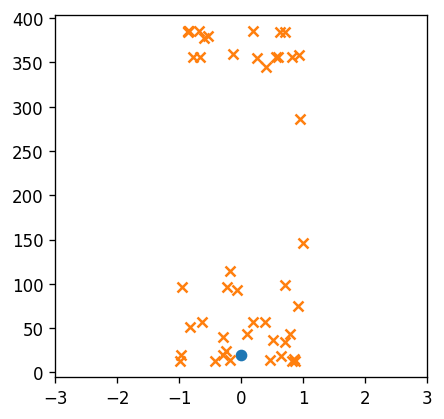

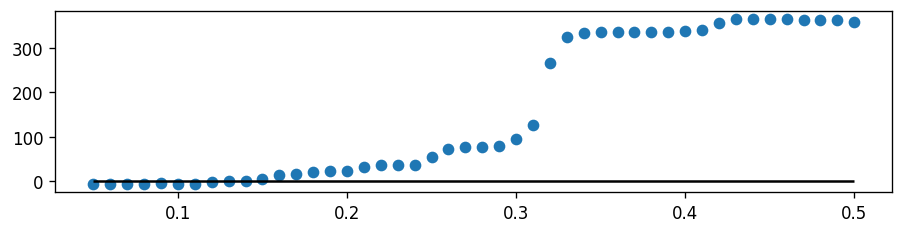

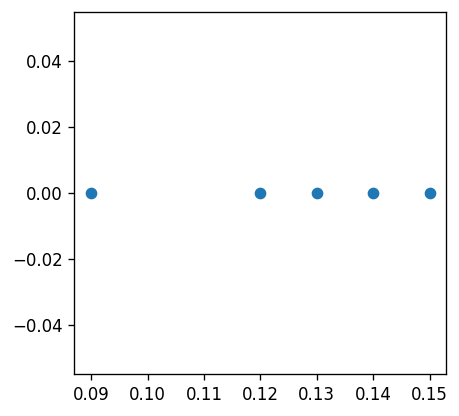

In [48]:
viz_page_results(a_pm, figsize=(4, 4))
viz_page_th_res_curve(a_pm, diff=True, figsize=(9, 2))
viz_ths_in_margin(a_pm, 0, 5, figsize=(4, 4))

Plot all the margins of all pages. Each line is a page and each dot is a threshold run that stayed within the margin.
The x-axis' value of the points are the threshold values.

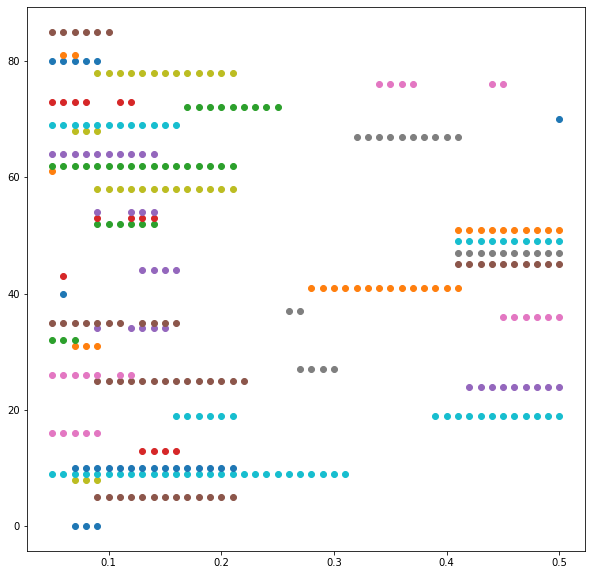

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
for idx, pm in enumerate(all_page_metas.values()):
    viz_ths_in_margin(pm, idx, 5, fig=fig, ax=ax)

The following methods get the `upto` best (closest to the ground truth) cases within the margin of +/- `maxerr`.

In [34]:
def get_closest_ths(pm: fm.PageMeta, upto: int, maxerr=5) -> t.Tuple[np.array, np.array, np.array]:
    """ ths, n_drecs, diffs """
    ths, n_drecs, diffs = get_data_points_within_margin(pm, maxerr)
    accepted = [x for x in sorted(zip(ths, n_drecs, abs(diffs)), key=lambda x: x[1])][:upto]
    return tuple(zip(*accepted)) if accepted else (np.array([]), np.array([]), np.array([]))


def viz_closest_ths(pm: fm.PageMeta, y_val, upto, maxerr=5, figsize=None, fig=None, ax=None):
    xs, _, _ = get_closest_ths(pm, upto, maxerr)
    figsize = figsize or (10, 10)
    fig = fig or plt.figure(figsize=figsize, dpi=120)
    ax = ax or fig.gca()
    ax.scatter(xs, [y_val for _ in range(len(xs))])
    return fig, ax

The following cells will get the best runs within a tight margin to figure out reasonable candidates for inspection.
Then it prints a list of pages that might be worth checking.

In [35]:
best_ones = {
    pmid: (th, drecs_by_run[(pm.page_id, th)]) 
    for pmid, pm in all_page_metas.items()
    for th, _, _ in zip(*get_closest_ths(pm, 1, 0))
}
print(len(all_page_metas), len(best_ones))

86 19


In [36]:
a_best_pmid = list(best_ones.keys())[random.randint(0, len(best_ones) - 1)]
a_best_pm = all_page_metas[a_best_pmid]

In [37]:
a_best_th, a_best_drecs = best_ones[a_best_pmid]
a_best_drs = a_best_pm.load_precomputed_data_regions(a_best_th, 10)
a_best_doc = a_best_pm.get_named_nodes_html_tree()

In [39]:
data_records_nodes = core.get_data_records_as_nodes(a_best_doc, a_best_drecs)

In [40]:
core.paint_data_records(data_records_nodes)
fm.PageMeta.persist_html(a_best_pm.colored_html, a_best_doc)
print(str(a_best_pm.colored_html))

/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-23-2303---bf7-747-a31-colored.html


In [41]:
for a_best_pmid in list(best_ones.keys()):
    try:
        a_best_pm = all_page_metas[a_best_pmid]
        a_best_th, a_best_drecs = best_ones[a_best_pmid]
        a_best_drs = a_best_pm.load_precomputed_data_regions(a_best_th, 10)
        a_best_doc = a_best_pm.get_named_nodes_html_tree()
        data_records_nodes = core.get_data_records_as_nodes(a_best_doc, a_best_drecs)
        if any(len(drec) == 0 for drec in data_records_nodes):
            print(a_best_pmid)
    except Exception as ex:
        import traceback
        print(ex)
        print(a_best_pmid)
        traceback.print_stack()


In [42]:
for a_best_pmid in list(best_ones.keys()):
    try:
        a_best_pm = all_page_metas[a_best_pmid]
        a_best_th, a_best_drecs = best_ones[a_best_pmid]
        a_best_drs = a_best_pm.load_precomputed_data_regions(a_best_th, 10)
        a_best_doc = a_best_pm.get_named_nodes_html_tree()
        data_records_nodes = core.get_data_records_as_nodes(a_best_doc, a_best_drecs)
        core.paint_data_records(data_records_nodes)
        fm.PageMeta.persist_html(a_best_pm.colored_html, a_best_doc)
        
        print(a_best_pm.n_data_records)
        print(a_best_pm.url)
        print(str(a_best_pm.raw_html))
        print(str(a_best_pm.colored_html))
        print("")
    
    except Exception as ex:
        import traceback
        print(ex)
        print(a_best_pmid)
        traceback.print_stack()
    

12
https://www.toysrus.com/shop-by-category/games-and-puzzles/puzzles/
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-24-0014---23e-d57-219-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-24-0014---23e-d57-219-colored.html

7
https://www.radioshack.com/collections/robotics
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-24-0106---320-3a7-e62-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-24-0106---320-3a7-e62-colored.html

28
https://www.barnesandnoble.com/b/coming-soon/books/_/N-1oyfZ29Z8q8
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-23-2300---347-344-928-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-23-2300---347-344-928-colored.html

10
http://www.ubid.com/
/home/joaopcbertoldo/repos/pymdr/outputs/raw_htmls/2020-03-24-0038---4c2-e2f-0f8-raw.html
/home/joaopcbertoldo/repos/pymdr/outputs/results/2020-03-24-0038---4c2-e2f-0f8-colored.html

11
https://www.toysrus.com/toy-trends/storytime_readi